In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)
torch.manual_seed(42)

In [4]:
class TrainingParams:
    feat_path = "./features_new"
    save_path = "./saved_results"
    model_name = "cnn_model_new_s_v1.0.h5"
    train_csv_loc = "./features/sa_train.csv"
    val_csv_loc = "./features/sa_val.csv"
    test_csv_loc = "./features/sa_test.csv"
    stat_csv_name = "stat_v1.2.csv"
    batch_size = 64
    lr = 1e-3
    max_epoch = 10

In [5]:
class CustomLoader(Dataset):
    def __init__(self, feat_path, csv_path, pct=1, train=False):
        self.feat_path = feat_path
        self.csv_path = csv_path
        df = pd.read_csv(self.csv_path)
        if train == True:
            df = df.sample(frac=pct)
        self.info_list = df.values.tolist()
        del df

    def __len__(self):
        return len(self.info_list)

    def __getitem__(self, item):
        folder, name, label = self.info_list[item]
        feat_loc = os.path.join(self.feat_path, str(folder), '{}.npy'.format(name.split(".")[0]))
        feat = np.load(feat_loc)
        return feat, label


def load_data(batch_size, feat_path, csv_path, shuffle, pct=1, train=False):
    dataset = CustomLoader(
        feat_path=feat_path,
        csv_path=csv_path,
        pct=pct,
        train=train
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle
    )
    return data_loader

In [6]:
class ConvBlock(nn.Module):
    def __init__(
            self,
            input_channel,
            output_channel,
            kernel=3,
            stride=1,
            padding=0
    ):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel, stride=stride, padding=padding),
            nn.BatchNorm2d(output_channel),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv_block(x)
        return x


class FullyConnectedBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(FullyConnectedBlock, self).__init__()
        self.fc_block = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.BatchNorm1d(num_features=out_features),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.fc_block(x)
        return x


class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(in_features=2304, out_features=64)
        self.bn6 = nn.BatchNorm1d(num_features=64)
        self.d2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(in_features=64, out_features=10)

    
    def forward(self, x):
        outputs = []
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = F.relu(x)
        outputs.append(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = F.relu(x)
        outputs.append(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = F.relu(x)
        outputs.append(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.bn6(x)
        x = F.relu(x)
        x = self.d2(x)
        x = self.fc3(x)
        return x, outputs

In [7]:
class IndividualEEModel(nn.Module):
    def __init__(self, in_features):
        super(IndividualEEModel, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=in_features, out_features=10)
    
    def forward(self, x):
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [8]:
class GeneralEEModel(nn.Module):
    def __init__(self):
        super(GeneralEEModel, self).__init__()
        self.pool_kernels = [(2, 5, 5), (2, 2, 2), (2, 1, 1)]
        self.dilations = [(1, 1, 1), (1, 2, 2), (1, 2, 2)]
#         self.conv = nn.Conv2d(in_channels=320, out_channels=16, kernel_size=3, padding="same")
        self.bn = nn.BatchNorm2d(num_features=16)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=2016, out_features=10)
    
    def forward(self, x, inference=False):
        pooled_outs = []
        for layer, out in enumerate(x):
            pool_3d = nn.MaxPool3d(kernel_size=self.pool_kernels[layer], dilation=self.dilations[layer])
            pooled_outs.append(pool_3d(out))
        x = torch.cat(pooled_outs, dim=1)
        x = self.flatten(x)
        scores = self.fc(x)
        return scores

In [9]:
def simulate_exit(x, choice=None):
    if choice is not None:
        choice = choice
    else:
        choice = np.random.choice(np.arange(0, 3), p=[.34, .33, .33])
    batch_size = x[0].shape[0]
    reshaped_output = []
    for i in range(3):
        if i <= choice :
            reshaped_output.append(x[i])
        else:
            reshaped_output.append(torch.zeros_like(x[i]))
    return reshaped_output, choice

In [10]:
def train(baseline, exit_model, layer, epochs, criterion, 
          optimizer, train_loader, val_loader, model_name, gen_ee=False):
    best_val_epoch, best_val_loss = 0, 1e6
    break_flag = 0
    for epoch in range(epochs):  # loop over the dataset multiple times
        exit_model.train()
        t_loss = 0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader):
            images, labels = data
            images = torch.tensor(images).to(device).float()
            labels = torch.tensor(labels).to(device)
            optimizer.zero_grad()
            _, outs = baseline(images)
            if gen_ee:
                outs, choice = simulate_exit(outs)
                out = outs
            else:
                out = outs[layer]
            outputs = exit_model(out)
            loss = criterion(outputs, labels)
            t_loss += loss.item()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        t_loss = t_loss / (i+1)
        t_loss = round(t_loss, 5)
        t_acc = round(100*(correct / total), 5)
        exit_model.eval()
        v_loss = 0
        correct = 0
        total = 0
        for i, data in enumerate(val_loader):
            images, labels = data
            images = torch.tensor(images).to(device).float()
            labels = torch.tensor(labels).to(device)
            _, outs = baseline(images)
            if gen_ee:
                outs, choice = simulate_exit(outs)
                out = outs
            else:
                out = outs[layer]
            outputs = exit_model(out)
            loss = criterion(outputs, labels)
            v_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        v_loss = v_loss/(i+1)
        v_loss = round(v_loss, 5)
        v_acc = round(100*(correct / total), 5)
        if v_loss <= best_val_loss:
            torch.save(exit_model.state_dict(), model_name)
            best_val_epoch = epoch + 1
            best_val_loss = v_loss
            break_flag = 0
        else:
            break_flag += 1
        print(f'Epoch[{epoch+1}]: t_loss: {t_loss} t_acc: {t_acc} v_loss: {v_loss} v_acc: {v_acc}')
        if break_flag >19 :
            break
    print('Finished Training')
    print('Best model saved at epoch: ', best_val_epoch)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
training_params = TrainingParams()
train_loader = load_data(
    batch_size=training_params.batch_size,
    feat_path=training_params.feat_path,
    csv_path=training_params.train_csv_loc,
    shuffle=True,
    pct=.01,
    train=True
)
val_loader = load_data(
    batch_size=training_params.batch_size,
    feat_path=training_params.feat_path,
    csv_path=training_params.val_csv_loc,
    shuffle=False
)
test_loader = load_data(
    batch_size=training_params.batch_size,
    feat_path=training_params.feat_path,
    csv_path=training_params.test_csv_loc,
    shuffle=False
)

In [13]:
baseline = Baseline().to(device)
baseline.load_state_dict(torch.load("baseline_kws_new_s_compressed.h5", map_location='cpu'))
baseline.eval()

Baseline(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2304, out_features=64, bias=True)
  (bn6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in

In [14]:
# in_features = []
# m = nn.MaxPool2d(kernel_size=2)
# f = nn.Flatten()
# _, outs = baseline(torch.randn(2, 1, 65, 65).to(device))
# for out in outs:
#     xx = f(m(out))
#     in_features.append(xx.shape[1])

In [15]:
pooled_outs = []
pool_kernels = [(2, 5, 5), (2, 2, 2), (2, 1, 1)]
dilations = [(1, 1, 1), (1, 2, 2), (1, 2, 2)]
_, outs = baseline(torch.randn(2, 1, 65, 65).to(device))
for layer, out in enumerate(outs):
    pool_3d = nn.MaxPool3d(kernel_size=pool_kernels[layer], dilation=dilations[layer])
    pooled = pool_3d(out)
    pooled_outs.append(pooled)
    print(out.shape, pooled.shape)
xx = torch.cat(pooled_outs, dim=1)
print(xx.shape)
flatten = nn.Flatten()
xx = flatten(xx)
print(xx.shape)

torch.Size([2, 16, 31, 31]) torch.Size([2, 8, 6, 6])
torch.Size([2, 32, 14, 14]) torch.Size([2, 16, 6, 6])
torch.Size([2, 64, 6, 6]) torch.Size([2, 32, 6, 6])
torch.Size([2, 56, 6, 6])
torch.Size([2, 2016])


In [16]:
# result_dict = {}
# result_dict["accuracy"] = []
# for ii, in_feature in enumerate(in_features):
#     print(f'Training for exit layer: {ii+1}')
#     precisions, recall, f1 = [], [], []
#     learning_rate = 1e-3
#     exit_model = IndividualEEModel(in_features=in_feature).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(exit_model.parameters(), lr=1e-3, momentum=0.9)
#     epochs = 50
#     ee_model_name = "ind_ee_cifar10_m.h5"
#     train(baseline, exit_model, ii, epochs, criterion, optimizer, train_loader, val_loader, ee_model_name)
#     exit_model.load_state_dict(torch.load(ee_model_name, map_location='cpu'))
#     exit_model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad(): 
#         true_y, pred_y = [], []
#         for i, data in enumerate(test_loader):
#             images, labels = data
# #             images, labels = images.to(device), labels.to(device)
#             images = torch.tensor(images).to(device).float()
#             labels = torch.tensor(labels).to(device)
#             _, outs = baseline(images)
#             outputs = exit_model(outs[ii])
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             pred_y = pred_y + list(predicted.detach().cpu().numpy())
#             true_y = true_y + list(labels.detach().cpu().numpy())
#         report = classification_report(true_y, pred_y, output_dict=True)
#         result_dict["accuracy"].append(report["accuracy"])
#         for i, (key, value) in enumerate(report.items()):
#             if i < 10:
#                 precisions.append(value['precision'])
#                 recall.append(value['recall'])
#                 f1.append(value['f1-score'])
#         result_dict[ii] = {
#             'precision': precisions,
#             'recall': recall,
#             'f1': f1,
#             'conf_mat': confusion_matrix(true_y, pred_y)
#         }

In [17]:
# fig, axes = plt.subplots(len(in_features), 1, figsize=(15, 15))
# class_names = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
# axes = axes.ravel()
# bar_width = 0.25
# for i, ax in enumerate(axes):
#     precisions = result_dict[i]['precision']
#     recall = result_dict[i]['recall']
#     f1 = result_dict[i]['f1']
#     r1 = np.arange(len(precisions))
#     r2 = [x + bar_width for x in r1]
#     r3 = [x + bar_width for x in r2]
#     ax.bar(r1, precisions, color='blue', width=bar_width, edgecolor='white', label='Precision')
#     ax.bar(r2, recall, color='green', width=bar_width, edgecolor='white', label='Recall')
#     ax.bar(r3, f1, color='orange', width=bar_width, edgecolor='white', label='F1-score')
#     ax.set_title(str(i))
#     ax.set_xticks([r + bar_width for r in range(len(precisions))], class_names)
#     ax.grid()
# plt.xlabel('Class', fontweight='bold')
# lines_labels = [ax.get_legend_handles_labels()]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines, labels, loc="upper center", ncol=3, fontsize=18)
# plt.tight_layout(pad=3)
# plt.show()

In [18]:
# ind_accuracies = []
# for i, accuracy in enumerate(result_dict['accuracy']):
#     accuracy = round(accuracy, 4)
#     precision = round(np.mean(result_dict[i]["precision"]), 4)
#     recall = round(np.mean(result_dict[i]["recall"]), 4)
#     f1 = round(np.mean(result_dict[i]["f1"]), 4)
#     ind_accuracies.append(accuracy)
#     print(f'Layer {i+1}: Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | f1-score: {f1}')    

In [19]:
# in_features = []
# pool_kernels = [(1, 9, 9), (1, 4, 4), (1, 2, 2)]
# dilations = [(1, 1, 1), (1, 2, 2), (1, 2, 2)]
# f = nn.Flatten()
# _, outs = baseline(torch.randn(2, 1, 65, 65).to(device))
# for i, out in enumerate(outs):
#     pool = nn.MaxPool3d(kernel_size=pool_kernels[i], dilation=dilations[i])
#     p = pool(out)
#     in_features.append(p)
#     print(out.shape, p.shape)
# x = torch.cat(in_features, dim=1)
# x = x.view(-1)
# print(x.shape)

In [20]:
result_dict = {}
result_dict["accuracy"] = []
in_features = [0]
for ii, in_feature in enumerate(in_features):
    precisions, recall, f1 = [], [], []
    learning_rate = 5e-3
    exit_model = GeneralEEModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(exit_model.parameters(), lr=learning_rate, momentum=0.9)
    epochs = 100
    ee_model_name = "gen_ee_kws_s_stft.h5"
    train(baseline, exit_model, ii, epochs, criterion, optimizer, 
          train_loader, val_loader, ee_model_name, gen_ee=True)
    exit_model.load_state_dict(torch.load(ee_model_name, map_location='cpu'))
    exit_model.eval()
    correct = 0
    total = 0
    with torch.no_grad(): 
        true_y, pred_y = [], []
        for i, data in enumerate(test_loader):
            images, labels = data
            images, labels = images.to(device).float(), labels.to(device)
            _, outs = baseline(images)
            outputs = exit_model(outs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pred_y = pred_y + list(predicted.detach().cpu().numpy())
            true_y = true_y + list(labels.detach().cpu().numpy())
        report = classification_report(true_y, pred_y, output_dict=True)
        result_dict["accuracy"].append(report["accuracy"])
        for i, (key, value) in enumerate(report.items()):
            if i < 10:
                precisions.append(value['precision'])
                recall.append(value['recall'])
                f1.append(value['f1-score'])
        result_dict[ii] = {
            'precision': precisions,
            'recall': recall,
            'f1': f1,
            'conf_mat': confusion_matrix(true_y, pred_y)
        }

/tmp/ipykernel_1301800/1134326673.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(device).float()
/tmp/ipykernel_1301800/1134326673.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
/tmp/ipykernel_1301800/1134326673.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(device).float()
/tmp/ipykernel_1301800/1134326673.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

Epoch[1]: t_loss: 2.41778 t_acc: 12.96296 v_loss: 2.47804 v_acc: 11.05345
Epoch[2]: t_loss: 2.27992 t_acc: 14.07407 v_loss: 2.73824 v_acc: 10.97561
Epoch[3]: t_loss: 2.31767 t_acc: 16.2963 v_loss: 2.69335 v_acc: 14.99741
Epoch[4]: t_loss: 2.31314 t_acc: 19.62963 v_loss: 2.68267 v_acc: 15.69798
Epoch[5]: t_loss: 2.30659 t_acc: 21.48148 v_loss: 2.92639 v_acc: 18.75973
Epoch[6]: t_loss: 2.22516 t_acc: 27.03704 v_loss: 2.84303 v_acc: 19.4603
Epoch[7]: t_loss: 2.42759 t_acc: 29.25926 v_loss: 2.93812 v_acc: 19.09704
Epoch[8]: t_loss: 2.14988 t_acc: 23.33333 v_loss: 2.82019 v_acc: 16.52828
Epoch[9]: t_loss: 1.98123 t_acc: 37.40741 v_loss: 2.67583 v_acc: 23.50804
Epoch[10]: t_loss: 2.21632 t_acc: 22.96296 v_loss: 2.63227 v_acc: 23.14478
Epoch[11]: t_loss: 2.01916 t_acc: 34.44444 v_loss: 2.70699 v_acc: 22.41827
Epoch[12]: t_loss: 1.90107 t_acc: 31.48148 v_loss: 2.53862 v_acc: 21.76959
Epoch[13]: t_loss: 1.6328 t_acc: 43.33333 v_loss: 2.58633 v_acc: 22.1069
Epoch[14]: t_loss: 1.72775 t_acc: 37.7

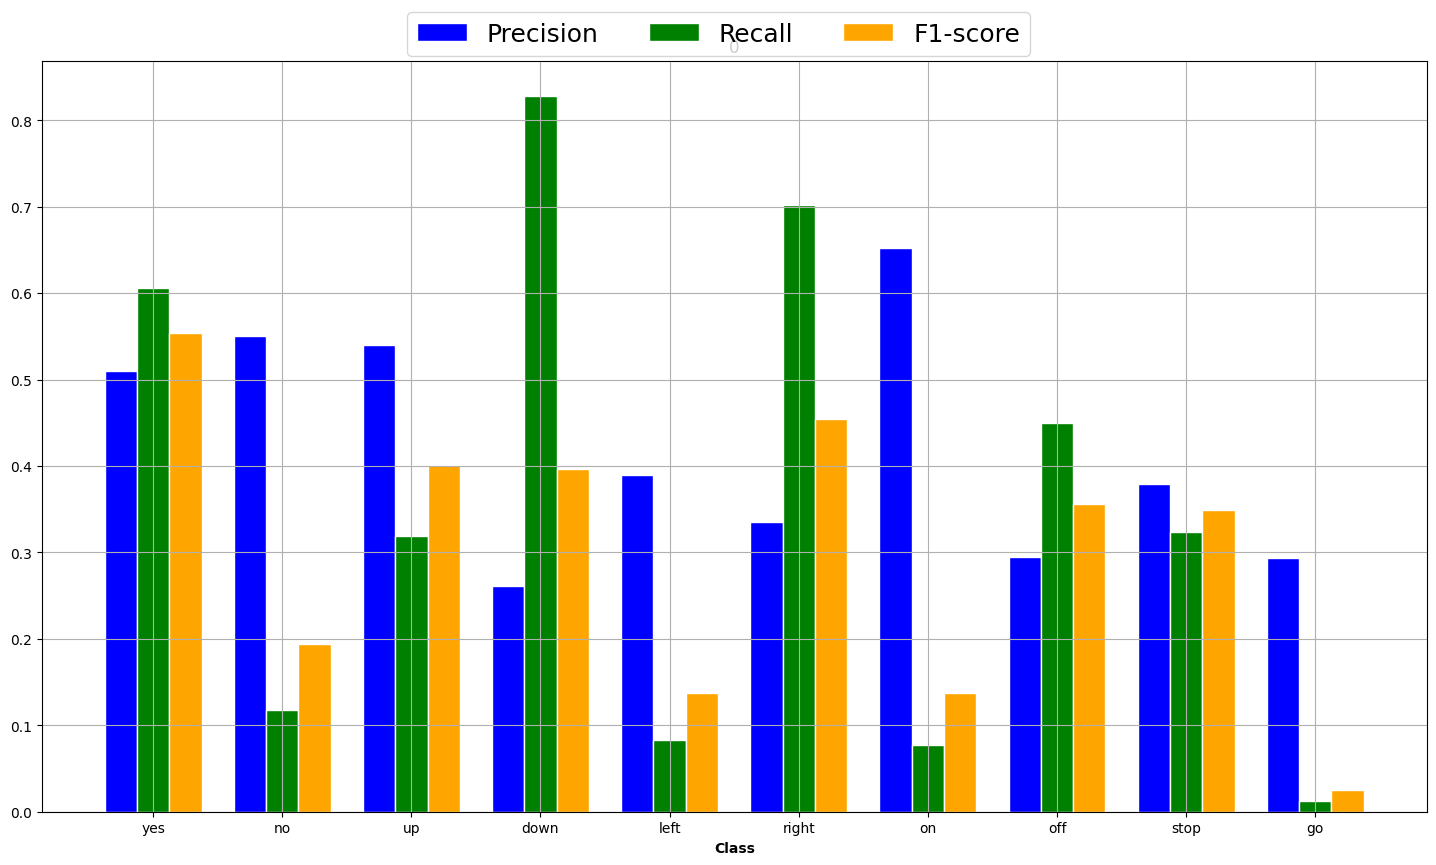

In [21]:
fig, ax = plt.subplots(len(in_features), 1, figsize=(15, 9))
class_names = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
bar_width = 0.25
i = 0
precisions = result_dict[i]['precision']
recall = result_dict[i]['recall']
f1 = result_dict[i]['f1']
r1 = np.arange(len(precisions))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
ax.bar(r1, precisions, color='blue', width=bar_width, edgecolor='white', label='Precision')
ax.bar(r2, recall, color='green', width=bar_width, edgecolor='white', label='Recall')
ax.bar(r3, f1, color='orange', width=bar_width, edgecolor='white', label='F1-score')
ax.set_title(str(i))
ax.set_xticks([r + bar_width for r in range(len(precisions))], class_names)
ax.grid()
plt.xlabel('Class', fontweight='bold')
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper center", ncol=3, fontsize=18)
plt.tight_layout(pad=3)
plt.show()

In [22]:
accuracies = []
for choice in range(3):
    true_y, pred_y = [], []
    for i, data in enumerate(test_loader):
        images, labels = data
        images, labels = images.to(device).float(), labels.to(device)
        _, outs = baseline(images)
        outs, _ = simulate_exit(outs, choice=choice)
        outputs = exit_model(outs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred_y = pred_y + list(predicted.detach().cpu().numpy())
        true_y = true_y + list(labels.detach().cpu().numpy())
    report = classification_report(true_y, pred_y, output_dict=True)
    accuracies.append(report["accuracy"])
    print(f'Layer: {choice+1} | Accuracy: {report["accuracy"]}')

Layer: 1 | Accuracy: 0.16368352788586252
Layer: 2 | Accuracy: 0.2569390402075227
Layer: 3 | Accuracy: 0.35071335927367053


In [23]:
# plt.figure(figsize=(15, 7))
# x = [1, 2, 3]
# plt.plot(x, accuracies, 
#          marker='o', markerfacecolor='orange', markersize=12, color='red', linewidth=4,
#          label="General EE"
#         )
# plt.plot(x, ind_accuracies, 
#          marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,
#          label="Non-general EE"
#         )
# plt.axhline(0.92, marker='', color='olive', linewidth=4, linestyle='dashed', label="Baseline")
# plt.xlabel("Exit Layer", fontsize=24)
# plt.ylabel("Accuracy", fontsize=24)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.grid(color='k', linestyle='--', linewidth=1)
# plt.legend(loc="best", prop={'size': 18})
# plt.show()

In [24]:
accuracies

[0.16368352788586252, 0.2569390402075227, 0.35071335927367053]

In [25]:
# ind_accuracies